# Build SIR model

The SIR model is built from SI model which is from the homework.

# Mount to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Package

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import random
import numpy as np
from matplotlib import pyplot as plt
from queue import Queue
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Get files

In [ ]:
root_dir = '/content/drive/My Drive/Network Analysis and modeling/'    # add shortcut to drive, change root_dir to your drive 
base_dir = root_dir + 'Network Project/Code/'
edge_file = base_dir + 'Caltech36.txt'
attr_file = base_dir + 'Caltech36_attr.txt'

# Read files

In [ ]:
def read_file(attr_file, edge_file):
  G = nx.read_edgelist(edge_file, nodetype = int)

  f = open(attr_file, "r")
  next(f)
  i = 1
  for x in f:
    x.rstrip()
    attr_list = x.split('\t')
    G.nodes[i]['status'] = int(attr_list[0])
    G.nodes[i]['gender'] = int(attr_list[1])
    G.nodes[i]['major'] = int(attr_list[2])
    G.nodes[i]['dorm'] = int(attr_list[3])
    G.nodes[i]['year'] = int(attr_list[4])
    
    i = i + 1
  for edge in G.edges():
    if (G.nodes[edge[0]]['dorm'] == G.nodes[edge[1]]['dorm']):
      G[edge[0]][edge[1]]['weight'] = 2
    else:
      G[edge[0]][edge[1]]['weight'] = 1

  return G

# Networkx SIR model

## Assumption:


1.   Recovered people will not get reinfected again
2.   Infected patients have spreaded the covid until the patient recovered 
3.   patients always recover at night, so the patients can keep spreading on daytime of that day



## Base SIR

In [ ]:
def generateGfromPlatedPartitionModel(c, n, e):
    p_in = (2 * c + e) / (2 * n)
    p_out = (2 * c - e) / (2 * n)
    G = nx.planted_partition_graph(2, int(n/2), p_in, p_out)
    return G


In [ ]:
class SIR_base:
  def __init__(self, p_infect, p_recover, G, start_node):
    self.G = G
    self.p_infect = p_infect
    self.p_recover = p_recover
    self.max_level = 1
    self.epidemic_size = 0
    self.susceptible_size_list = []
    self.infected_size_list = []
    self.recovered_size_list = []
    self.recover_node_list = []
    self.start_node = start_node
  
  
  def simulation(self):
    infected_dict = {}
    # Initializing a queue
    q = Queue(0)
    infected_node = start_node 
    q.put(infected_node)
    infected_dict[infected_node] = 1
    
    level = 1
    
    while (not q.empty()):
        size = q.qsize()
        self.infected_size_list.append(size)
        self.susceptible_size_list.append(len(self.G.nodes) - size - len(self.recover_node_list))
        self.recovered_size_list.append(len(self.recover_node_list))
        while (size > 0):
            size -= 1
            infected_node = q.get()
            if (np.random.rand() < self.p_recover):
              self.recover_node_list.append(infected_node)
              infected_dict[infected_node] = -1
            else:
              q.put(infected_node)
            to_infect_edges_list = self.G.edges(infected_node)
            to_infect_list = [j for i in list(to_infect_edges_list) for j in i if (infected_dict.get(j, 0) == 0)]
            to_infect_list = list(set(to_infect_list))
            for node in to_infect_list:
                if (infected_node == node):
                    continue
                if (infected_dict.get(node) == 1):
                    continue
                if (np.random.rand() < self.p_infect * self.G[infected_node][node]['weight']):
                    infected_dict[node] = 1
                    q.put(node)
                    max_level = level + 1
 
        level += 1
       
    infected_list = [k for k,v in infected_dict.items() if v == 1]
    epidemic_size = len(infected_list)/len(self.G.nodes())


  def plot(self, title):
    plt.plot([i for i in range (len(self.susceptible_size_list))], self.susceptible_size_list, label='susceptible')
    plt.plot([i for i in range (len(self.infected_size_list))], self.infected_size_list, label='infected')
    plt.plot([i for i in range (len(self.recovered_size_list))], self.recovered_size_list, label='recovered')
    plt.legend()
    print(self.susceptible_size_list[-1])
    plt.xlabel('Timestemp')
    plt.ylabel('Population')
    plt.title('SIR MODEL ' + title)


20


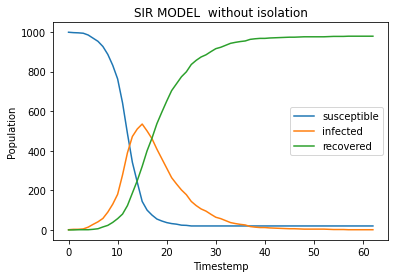

In [ ]:
# G = generateGfromPlatedPartitionModel(4, 1000, 0)
n = 10**3
G = nx.Graph()
G.add_nodes_from(np.arange(n))
for i in range(n):
    size = np.random.choice(np.arange(1,9))
    edges = np.random.choice(np.arange(n), size)
    for e in edges:
        G.add_edge(i, e)
for e in G.edges():
    G[e[0]][e[1]]['weight'] = np.random.randint(1,3)
start_node = random.randrange(0, len(G.nodes()))
situmulation_base = SIR_base(0.075, 0.143, G, start_node)
situmulation_base.simulation()
situmulation_base.plot(' without isolation')

## with Isolation

In [ ]:
class SIR_Isolation(SIR_base):
  def __init__(self, p_infect, p_recover, G, start_node):
    SIR_base.__init__(self, p_infect, p_recover, G, start_node)
  
  def simulation(self):
    infected_dict = {}
    # Initializing a queuez
    q = Queue(0)
    infected_node = self.start_node
    q.put(infected_node)
    infected_dict[infected_node] = 1
    
    level = 1
    
    while (not q.empty()):
        size = q.qsize()
        self.infected_size_list.append(size)
        self.susceptible_size_list.append(len(self.G.nodes) - size - len(self.recover_node_list))
        self.recovered_size_list.append(len(self.recover_node_list))
        while (size > 0):
            size -= 1
            infected_node = q.get()
            if (np.random.rand() < self.p_recover):
              self.recover_node_list.append(infected_node)
              infected_dict[infected_node] = -1
            else:
              q.put(infected_node)
            to_infect_edges_list = self.G.edges(infected_node)
            to_infect_list = [j for i in list(to_infect_edges_list) for j in i if (infected_dict.get(j, 0) == 0)]

            to_infect_list = list(set(to_infect_list))
            for node in to_infect_list:
                if (infected_node == node):
                    continue
                if (infected_dict.get(node) == 1):
                    continue
                if (self.G[infected_node][node]['weight'] == 1):
                    continue
                if (self.G[infected_node][node]['weight'] == 2 and np.random.rand() < self.p_infect * self.G[infected_node][node]['weight']):
                    infected_dict[node] = 1
                    q.put(node)
                    max_level = level + 1
 
        level += 1
       
    infected_list = [k for k,v in infected_dict.items() if v == 1]
    epidemic_size = len(infected_list)/len(self.G.nodes())



96


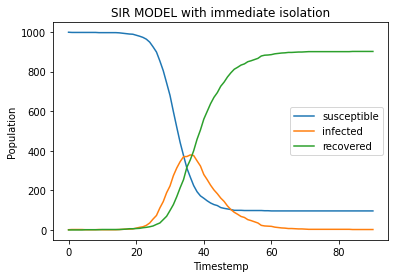

In [ ]:
# G = generateGfromPlatedPartitionModel(4, 1000, 0)
n = 10**3
G = nx.Graph()
G.add_nodes_from(np.arange(n))
for i in range(n):
    size = np.random.choice(np.arange(1,9))
    edges = np.random.choice(np.arange(n), size)
    for e in edges:
        G.add_edge(i, e)
for e in G.edges():
    G[e[0]][e[1]]['weight'] = np.random.randint(1,3)
start_node = random.randrange(0, len(G.nodes()))
situmulation_isolation = SIR_Isolation(0.075, 0.143, G, start_node)
situmulation_isolation.simulation()
situmulation_isolation.plot('with immediate isolation')

## Delay Isolation SIR

In [ ]:
class SIR_Delay_Isolation(SIR_base):
  def __init__(self, p_infect, p_recover, G, start_node, spread_day):
    SIR_base.__init__(self, p_infect, p_recover, G, start_node)
    self.spread_day = spread_day
  
  def simulation(self):
    infected_dict = {}
    # Initializing a queue
    q = Queue(0)
    infected_node = self.start_node
    q.put(infected_node)
    infected_dict[infected_node] = 1
    
    level = 1

    count_down = np.zeros(len(self.G.nodes()) + 1)
    count_down[infected_node] = self.spread_day
    while (not q.empty()):
        size = q.qsize()
        self.infected_size_list.append(size)
        self.susceptible_size_list.append(len(self.G.nodes) - size - len(self.recover_node_list))
        self.recovered_size_list.append(len(self.recover_node_list))
        while (size > 0):
            size -= 1
            infected_node = q.get()
            
            #check whether the person recovers, assume if the person recovered, the he/she still spread virus today.
            # if (count_down[infected_node] == 0 and np.random.rand() < self.p_recover):
            if (np.random.rand() < self.p_recover):
              self.recover_node_list.append(infected_node)
              infected_dict[infected_node] = -1
              count_down[infected_node] = 0
            else:
              q.put(infected_node)
            to_infect_edges_list = self.G.edges(infected_node)
            to_infect_list = [j for i in list(to_infect_edges_list) for j in i if (infected_dict.get(j, 0) == 0)]

            to_infect_list = list(set(to_infect_list))
            for node in to_infect_list:
                if (infected_node == node):
                    continue
                if (infected_dict.get(node) == 1):
                    continue
                if ((count_down[infected_node] > 0 or self.G[infected_node][node]['weight'] == 2) and np.random.rand() < self.p_infect * self.G[infected_node][node]['weight']):
                    infected_dict[node] = 1
                    count_down[node] = self.spread_day
                    q.put(node)
                    max_level = level + 1
        
        count_down[count_down > 0] -= 1
        level += 1
       
    infected_list = [k for k,v in infected_dict.items() if v == 1]
    epidemic_size = len(infected_list)/len(self.G.nodes())



311


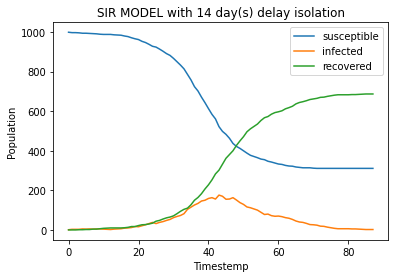

In [ ]:
G = generateGfromPlatedPartitionModel(4, 1000, 0)
for e in G.edges():
    G[e[0]][e[1]]['weight'] = np.random.randint(1,3)
spread_day = 14
start_node = random.randrange(0, len(G.nodes()))
situmulation_delay_isolation = SIR_Delay_Isolation(0.075, 0.143, G, start_node, spread_day)
situmulation_delay_isolation.simulation()
title = 'with ' + str(spread_day) + ' day(s) delay isolation'
situmulation_delay_isolation.plot(title)

# Run on real network Caltech36.txt

## Base SIR

37


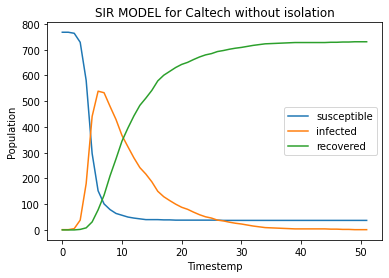

In [ ]:
G = read_file(attr_file, edge_file)
start_node = random.randrange(0, len(G.nodes()))
situmulation_Caltech = SIR_base(0.075, 0.143, G, start_node)
situmulation_Caltech.simulation()
situmulation_Caltech.plot('for Caltech without isolation')

## Isolation SIR


667


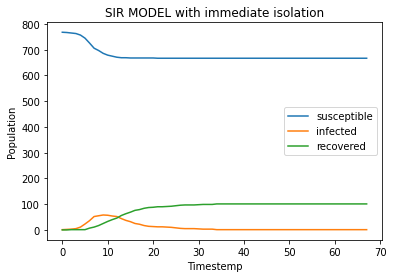

In [ ]:
G = read_file(attr_file, edge_file)
start_node = random.randrange(0, len(G.nodes()))
situmulation_isolation_Caltech = SIR_Isolation(0.075, 0.143, G, start_node)
situmulation_isolation_Caltech.simulation()
situmulation_isolation_Caltech.plot('with immediate isolation')

## Delay Isolation SIR

76


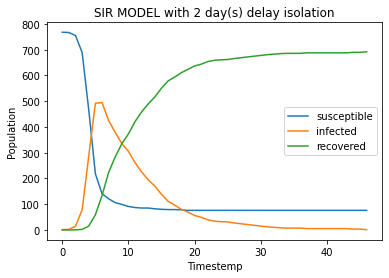

In [ ]:
G = read_file(attr_file, edge_file)
spread_day = 2
start_node = random.randrange(0, len(G.nodes()))
situmulation_delay_isolation_Caltech = SIR_Delay_Isolation(0.075, 0.143, G, start_node, spread_day)
situmulation_delay_isolation_Caltech.simulation()
title = 'with ' + str(spread_day) + ' day(s) delay isolation'
situmulation_delay_isolation_Caltech.plot(title)

## Degree, Harmonic, Eigen, Betweeness centrality

In [ ]:
high_degC = [709, 90, 223] 
low_degC = [713, 536, 533]
high_harC = [3, 709, 90, 223]
low_harC = [35, 147, 169, 437] 
high_eigC = [709, 90, 623] 
low_eigC =  [437, 169, 147, 35] 
high_betC = [3, 709, 223, 278]
low_betC = [751, 744, 743]
mix_degC = [709, 713]
mix_betC = [3, 751]

In [ ]:
def plot(title, susceptible_list, infected_list, recovered_list):
    for i in range(len(susceptible_list)):
      if (i == 0):
        label = ' High D'
        line = ':'
      else:
        label = ' LowdD D'
        line = '-'
      plt.plot([i for i in range (len(susceptible_list[i]))], susceptible_list[i], label='susceptible' + label, linestyle=line)
      plt.plot([i for i in range (len(infected_list[i]))], infected_list[i], label='infected' + label, linestyle=line)
      plt.plot([i for i in range (len(recovered_list[i]))], recovered_list[i], label='recovered' + label, linestyle=line)
    plt.legend()

    plt.xlabel('Timestemp')
    plt.ylabel('Population')
    plt.title('SIR MODEL ' + title)

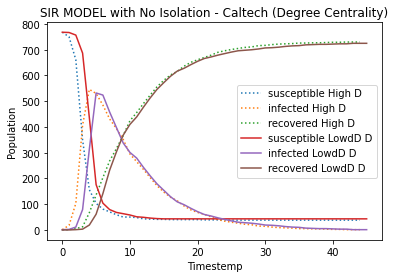

In [ ]:
G = read_file(attr_file, edge_file)
susceptible_list = []
infected_list = []
recovered_list = []

for node in mix_degC:  
  start_node = node
  situmulation_Caltech = SIR_base(0.075, 0.143, G, start_node)
  situmulation_Caltech.simulation()
  susceptible_list.append(situmulation_Caltech.susceptible_size_list)
  infected_list.append(situmulation_Caltech.infected_size_list)
  recovered_list.append(situmulation_Caltech.recovered_size_list)

title = 'with No Isolation - Caltech (Degree Centrality)'
plot(title, susceptible_list, infected_list, recovered_list)



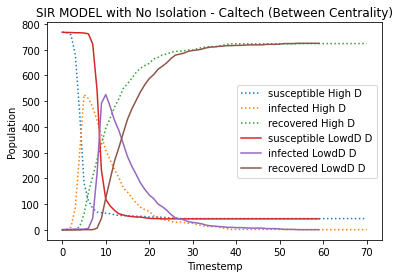

In [ ]:
G = read_file(attr_file, edge_file)
susceptible_list = []
infected_list = []
recovered_list = []

for node in mix_betC:  
  start_node = node
  situmulation_Caltech = SIR_base(0.075, 0.143, G, start_node)
  situmulation_Caltech.simulation()
  susceptible_list.append(situmulation_Caltech.susceptible_size_list)
  infected_list.append(situmulation_Caltech.infected_size_list)
  recovered_list.append(situmulation_Caltech.recovered_size_list)

title = 'with No Isolation - Caltech (Between Centrality)'
plot(title, susceptible_list, infected_list, recovered_list)


# [New Section](https://)

In [ ]:
class SEIR_simulator_I_isolation:
    def __init__(self, G, n, days, edgeList):
        self.n = n
        self.days = days
        self.p_se = 0.6   # prob S-E
        self.p_ei = 0.125 # prob E-I
        self.p_ir = 0.143 # prob I-R
        self.G = G
        self.G_grid = nx.Graph()
        self.edgeList = edgeList
        self.nodes = [0]*n
        # dicts for SEIR 
        # key: day
        # value: list of nodes
        self.SList = {}   
        self.EList = {}
        self.IList = {}
        self.RList = {}
        self.EIList = {}
        
        for timestep in range(self.days+7):
            self.SList[timestep] = []
            self.EList[timestep] = []
            self.IList[timestep] = []
            self.RList[timestep] = []
            self.EIList[timestep] = []
        self.spreadList = []
        self.gotList = []
        

    def SEIR_simulator(self):
        # begin with 1 infected node
        startNode = np.random.randint(0, n)
        self.nodes[startNode] = 1
        self.SList[0] = list(self.G.nodes())
        self.SList[0].remove(startNode)
        self.IList[0].append(startNode)
        self.spreadList.append(startNode)
        self.gotList.append(startNode)
        self.G_grid.add_node(startNode)
        
        # simulate for 40 days
        for day in range(1,self.days+1):
            self.SEI_stage(day)    # S -> E (0.6), E -> I (0.125)
            if day > 6:            
                self.isolate_I(day)# Isolation
                self.IR_stage(day) # I -> R (0.143)
        
        return list(self.SList.values()), list(self.EList.values()), list(self.IList.values()), list(self.RList.values())
        
    
    def SEI_stage(self, day):
        # Update dictionarys from day before
        self.SList[day] = list(set(self.SList[day] + self.SList[day-1]))
        self.EList[day] = list(set(self.EList[day] + self.EList[day-1]))
        self.IList[day] = list(set(self.IList[day] + self.IList[day-1]))
        self.EIList[day] = list(set(self.EIList[day] + self.EIList[day-1]))

        if day >= 6:
            for node in self.EList[day-6]:
                # nodes in E but not I return to S after 6 days
                if node in self.EList[day] and node not in self.gotList:
                    self.EList[day].remove(node)
                    self.SList[day].append(node)
                # nodes get I during E 6 days remove from E
                elif node in self.EList[day] and node in self.gotList:
                    self.EList[day].remove(node)
                    
#         print(day)       
#         print("S:",self.SList[day])
#         print("E:",self.EList[day])
#         print("I:",self.IList[day])
#         print("R:",self.RList[day])
#         print("-------------------------------------------------------------")

        # check nodes positive in E or I
        for node in self.spreadList:
            # Pass to neighbors
            for adj in list(self.G.adj[node]):
                # 0.6 prob got Exposed
                if self.nodes[adj] == 0 and self.G[adj][node]['weight'] == 2 and np.random.uniform(0,1) <= self.p_se:
                    # Exposed list
                    if adj not in self.EIList[day]:
                        self.EIList[day].append(adj)
                        self.EList[day].append(adj)
                    # Remove from SList
                    if adj in self.SList[day]:
                        self.SList[day].remove(adj)
                    # 0.125 prob E to I
                    if np.random.uniform(0,1) <= self.p_ei:
                        self.spreadList.append(adj)   # Ability to spread
                        self.nodes[adj] = 1           # Will not get infected again 
                        self.IList[day+6].append(adj) # Add in Infected dict 6 days after
                        self.gotList.append(adj)      # Track all the nodes has been infected in the history
                        self.EIList[day].remove(adj)  # Nodes won't be exposed again
                    
                    # Following 6 days, this nodes will not be in S
                    for d in range(day, day+6):
                        if adj in self.SList[d]:
                            self.SList[d].remove(adj)
            # print("During duration", days, "days, have total", len(list(set(self.gotList))), "people affected")
    
    def isolate_I(self, day):
#         self.IList[day] = list(set(self.IList[day] + self.IList[day-1]))
        self.G.remove_nodes_from(self.IList[day])
        for node in self.IList[day]:
            self.G_grid.add_node(node)
            if node in self.spreadList:
                self.spreadList.remove(node) # move to isolation, no more spread
            # print(self.G_grid.nodes())
            i_nodes = np.random.choice(list(self.G_grid.nodes()), 4)
            for i_node in i_nodes:
                if len(self.G_grid.edges(i_node)) < 4:
                    self.G_grid.add_edge(node, i_node)
            
        
    def IR_stage(self, day):
        # Update recover dict from day before
        self.RList[day] = list(set(self.RList[day] + self.RList[day-1]))
        
        # there is 0.143 prob everyday I to R
        for node in self.IList[day]:
            if np.random.uniform(0,1) <= self.p_ir:
                self.RList[day].append(node) # Add to Recover dict
                self.IList[day].remove(node) # Remove from Infected dict
                self.G_grid.remove_node(node)# remove from grid isolation
#                 if node in self.spreadList:
#                     self.spreadList.remove(node) # no longer able to spread
        
        

At timestep 7 have highest infected num: 48


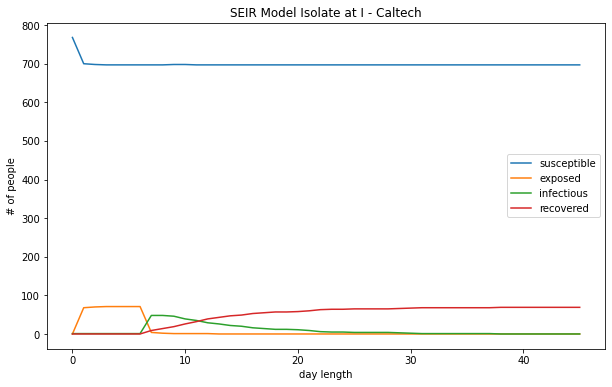

In [ ]:
days = 45
n = 100

G = read_file(attr_file, edge_file)
n_caltech = G.number_of_nodes()
caltech_edges = {}
# print(G_caltech2.nodes())
for node in G.nodes():
#     print(G_caltech2.edges(node))
    caltech_edges[node] = list(G.edges(node))

SEIR_caltech_I = SEIR_simulator_I_isolation(G, n_caltech+1, days, caltech_edges)
s_list2, e_list2, i_list2, r_list2 = SEIR_caltech_I.SEIR_simulator()

s2 = [len(s_list2[i]) for i in range(days+1)]
e2 = [len(e_list2[i]) for i in range(days+1)]
i2 = [len(i_list2[i]) for i in range(days+1)]
r2 = [len(r_list2[i]) for i in range(days+1)]
print("At timestep",i2.index(max(i2)), "have highest infected num:" , max(i2))

fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s2, label="susceptible")
plt.plot(np.arange(days+1), e2, label="exposed")
plt.plot(np.arange(days+1), i2, label="infectious")
plt.plot(np.arange(days+1), r2, label="recovered")

ax.set_title("SEIR Model Isolate at I - Caltech")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

In [ ]:
class SEIR_simulator_EI_isolation:
    def __init__(self, G, n, days, edgeList):
        self.n = n
        self.days = days
        self.p_se = 0.6   # prob S-E
        self.p_ei = 0.125 # prob E-I
        self.p_ir = 0.143 # prob I-R
        self.G = G
        self.G_grid = nx.Graph()
        self.edgeList = edgeList
        self.nodes = [0]*n
        self.SList = {}   
        self.EList = {}
        self.IList = {}
        self.RList = {}
        self.EIList = {}
        self.isolate = {}
        for timestep in range(self.days+7):
            self.SList[timestep] = []
            self.EList[timestep] = []
            self.IList[timestep] = []
            self.RList[timestep] = []
            self.EIList[timestep] = []
            self.isolate[timestep] = []
        self.spreadList = []
        self.gotList = []
        self.startNode = np.random.randint(0, n)
        

    def SEIR_simulator(self):
        
        self.nodes[self.startNode] = 1
        self.SList[0] = list(self.G.nodes())
        self.SList[0].remove(self.startNode)
        self.IList[0].append(self.startNode)
        self.spreadList.append(self.startNode)
        self.gotList.append(self.startNode)
        self.G_grid.add_node(self.startNode)
        
        # simulate for 40 days
        for day in range(1,self.days+1):
            self.SEI_stage(day)    # S -> E (0.6), E -> I (0.125)
            if day > 6: 
                self.IR_stage(day) # I -> R (0.143)
        
        return list(self.SList.values()), list(self.EList.values()), list(self.IList.values()), list(self.RList.values())
        
    
    def SEI_stage(self, day):
        # Update dictionarys from day before
        self.SList[day] = list(set(self.SList[day] + self.SList[day-1]))
        self.EList[day] = list(set(self.EList[day] + self.EList[day-1]))
        self.IList[day] = list(set(self.IList[day] + self.IList[day-1]))
        self.EIList[day] = list(set(self.EIList[day] + self.EIList[day-1]))
        self.isolate[day] = list(set(self.isolate[day] + self.isolate[day-1]))

        if day >= 6:
            for node in self.EList[day-6]:
                # nodes in E but not I return to S after 6 days
                if node in self.EList[day] and node not in self.gotList:
                    self.EList[day].remove(node)
                    self.SList[day].append(node)
                # nodes get I during E 6 days remove from E
                elif node in self.EList[day] and node in self.gotList:
                    self.EList[day].remove(node)

        # check nodes positive in E or I
        for node in self.spreadList:
            # Pass to neighbors
            for adj in list(self.G.adj[node]):
                # 0.6 prob got Exposed
                if self.nodes[adj] == 0 and self.G[adj][node]['weight'] == 2 and np.random.uniform(0,1) <= self.p_se:
                    # Exposed list
                    if adj not in self.EIList[day]:
                        self.EIList[day].append(adj)
                        self.EList[day].append(adj)
                    # Remove from SList
                    if adj in self.SList[day]:
                        self.SList[day].remove(adj)
                    # 0.125 prob E to I
                    if np.random.uniform(0,1) <= self.p_ei:
                        self.spreadList.append(adj)   # Ability to spread
                        self.nodes[adj] = 1           # Will not get infected again 
                        self.IList[day+6].append(adj) # Add in Infected dict 6 days after
                        self.gotList.append(adj)      # Track all the nodes has been infected in the history
                        self.EIList[day].remove(adj)  # Nodes won't be exposed again
                    
                    # Following 6 days, this nodes will not be in S
                    for d in range(day, day+6):
                        if adj in self.SList[d]:
                            self.SList[d].remove(adj)
                            
        # 2 days delay, then start isolate 50% esposed from day before
        if day > 2:
            self.isolate_EI(day) #Isolate
    
    def isolate_EI(self, day):
        
        print('Day',day,'In Isolation:')
#         print("Isolation list:", self.isolate[day])
#         print("nodes in list:", self.G_grid.nodes())
        
        # remove the ones after isolation
        if day >= 7:
            for node in self.isolate[day-6]:
                # not infected after isolation, put back in G
                if node in self.G_grid.nodes() and node not in self.gotList:
                    self.G_grid.remove_node(node)
                    if node in self.isolate[day]:
                        self.isolate[day].remove(node)
                    self.SList[day].append(node)
                    self.G.add_node(node)
                    # put back into original network
                    for adj in self.edgeList[node]:
                        if adj in self.G.nodes():
                            self.G.add_edge(adj, node)
            self.isolate_I(day) # Isolate all infected
        
        # add in new isolated nodes, 50% chance
        for i_node in list(set(self.EList[day-1])):
            if np.random.uniform(0,1) <= 0.5:
                if i_node in self.spreadList:
                    self.spreadList.remove(i_node)
                self.isolate[day].append(i_node)
                if i_node in self.G.nodes():
                    self.G.remove_node(i_node)
                self.isolate[day].append(i_node)
                n_nodes = np.random.choice(list(self.G_grid.nodes()), 4)
                self.G_grid.add_node(i_node)
                for n in n_nodes:
                    if len(list(self.G_grid.edges(n))) < 4:
                        self.G_grid.add_edge(i_node, n)

        # Grid isolation
#         p_se_isolation = 0.1
        for node in self.G_grid.nodes():
            if node in self.gotList:
                for adj in self.G_grid.adj[node]:
                    # during Isolation got Exposed
                    if self.nodes[adj] == 0 and np.random.uniform(0,1) <= self.p_se: #p_se_isolation:
                        # 0.125 prob E to I
                        if np.random.uniform(0,1) <= self.p_ei:
                            self.nodes[adj] = 1           # Will not get infected again 
                            self.IList[day+6].append(adj) # Add in Infected dict 6 days after
                            self.gotList.append(adj)      # Track all the nodes has been infected in the history
                            self.EIList[day].remove(adj)  # Nodes won't be exposed again
                            
    def isolate_I(self, day):
        # all infected nodes will be added in isolation
        self.G.remove_nodes_from(self.IList[day])
        for node in self.IList[day]:
            self.G_grid.add_node(node)
            if node in self.spreadList:
                self.spreadList.remove(node) # move to isolation, no more spread
            i_nodes = np.random.choice(list(self.G_grid.nodes()), 4)
            for i_node in i_nodes:
                if len(self.G_grid.edges(i_node)) < 4:
                    self.G_grid.add_edge(node, i_node)
            
        
    def IR_stage(self, day):
        # Update recover dict from day before
        self.RList[day] = list(set(self.RList[day] + self.RList[day-1]))
        
        # there is 0.143 prob everyday I to R
        for node in self.IList[day]:
            if np.random.uniform(0,1) <= self.p_ir:
                self.RList[day].append(node) # Add to Recover dict
                self.IList[day].remove(node) # Remove from Infected dict
                if node in self.G_grid.nodes():
                    self.G_grid.remove_node(node)# remove from grid isolation
        
        

Day 3 In Isolation:
Day 4 In Isolation:
Day 5 In Isolation:
Day 6 In Isolation:
Day 7 In Isolation:
Day 8 In Isolation:
Day 9 In Isolation:
Day 10 In Isolation:
Day 11 In Isolation:
Day 12 In Isolation:
Day 13 In Isolation:
Day 14 In Isolation:
Day 15 In Isolation:
Day 16 In Isolation:
Day 17 In Isolation:
Day 18 In Isolation:
Day 19 In Isolation:
Day 20 In Isolation:
Day 21 In Isolation:
Day 22 In Isolation:
Day 23 In Isolation:
Day 24 In Isolation:
Day 25 In Isolation:
Day 26 In Isolation:
Day 27 In Isolation:
Day 28 In Isolation:
Day 29 In Isolation:
Day 30 In Isolation:
Day 31 In Isolation:
Day 32 In Isolation:
Day 33 In Isolation:
Day 34 In Isolation:
Day 35 In Isolation:
Day 36 In Isolation:
Day 37 In Isolation:
Day 38 In Isolation:
Day 39 In Isolation:
Day 40 In Isolation:
Day 41 In Isolation:
Day 42 In Isolation:
Day 43 In Isolation:
Day 44 In Isolation:
Day 45 In Isolation:
At timestep 8 have highest infected num: 59


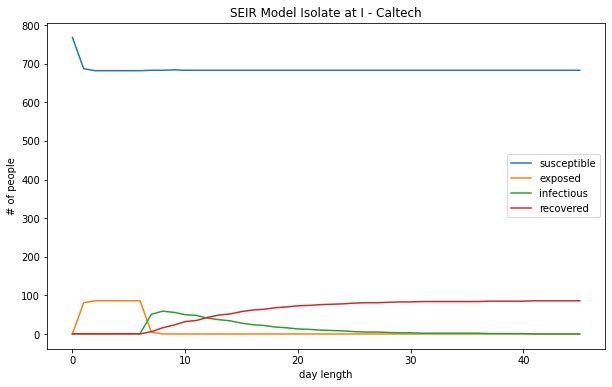

In [ ]:
days = 45
n = 100

G = read_file(attr_file, edge_file)
n_caltech = G.number_of_nodes()
caltech_edges = {}
# print(G_caltech2.nodes())
for node in G.nodes():
#     print(G_caltech2.edges(node))
    caltech_edges[node] = list(G.edges(node))

SEIR_caltech_I = SEIR_simulator_EI_isolation(G, n_caltech+1, days, caltech_edges)
s_list2, e_list2, i_list2, r_list2 = SEIR_caltech_I.SEIR_simulator()

s2 = [len(s_list2[i]) for i in range(days+1)]
e2 = [len(e_list2[i]) for i in range(days+1)]
i2 = [len(i_list2[i]) for i in range(days+1)]
r2 = [len(r_list2[i]) for i in range(days+1)]
print("At timestep",i2.index(max(i2)), "have highest infected num:" , max(i2))

fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s2, label="susceptible")
plt.plot(np.arange(days+1), e2, label="exposed")
plt.plot(np.arange(days+1), i2, label="infectious")
plt.plot(np.arange(days+1), r2, label="recovered")

ax.set_title("SEIR Model Isolate at I - Caltech")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()